In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (16, 8)

In [18]:
df = pd.read_csv('./all_stocks_5yr.csv', index_col=0 ,parse_dates=True)
grouped_by_date = df.groupby(['date']).mean()
grouped_by_date = grouped_by_date.resample(rule="W").mean()


<AxesSubplot:title={'center':'Data'}, xlabel='date'>

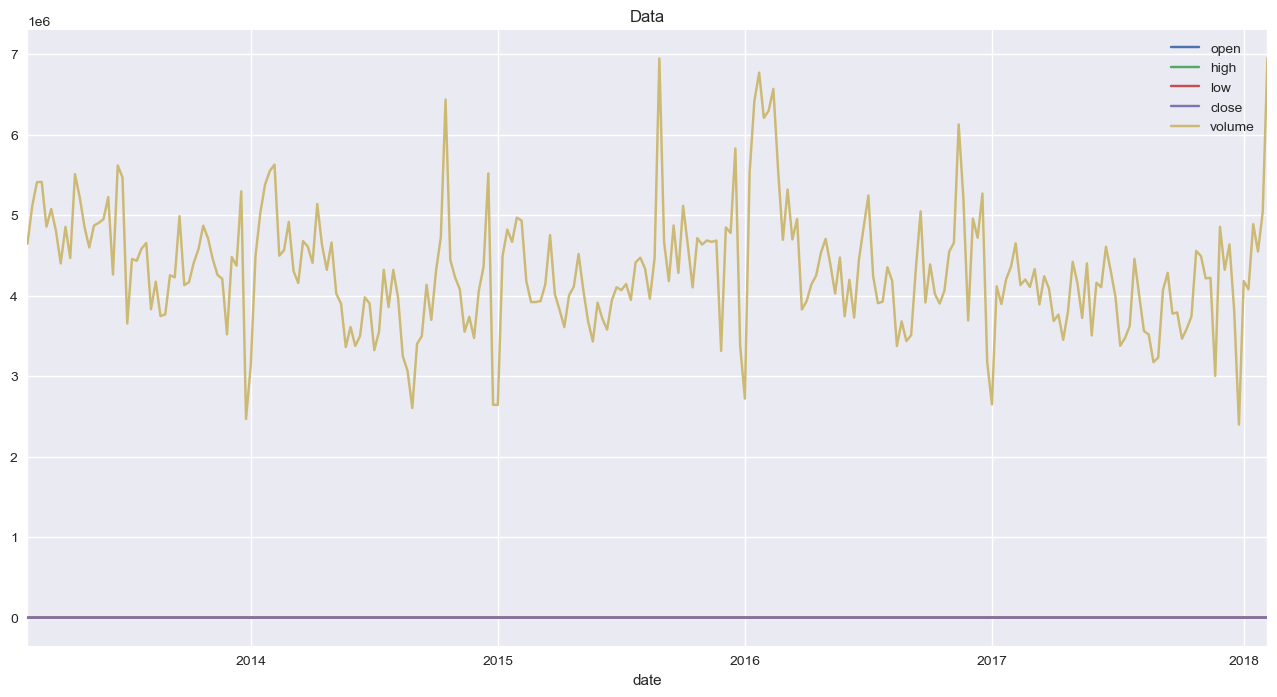

In [19]:

grouped_by_date.plot(title="Data")

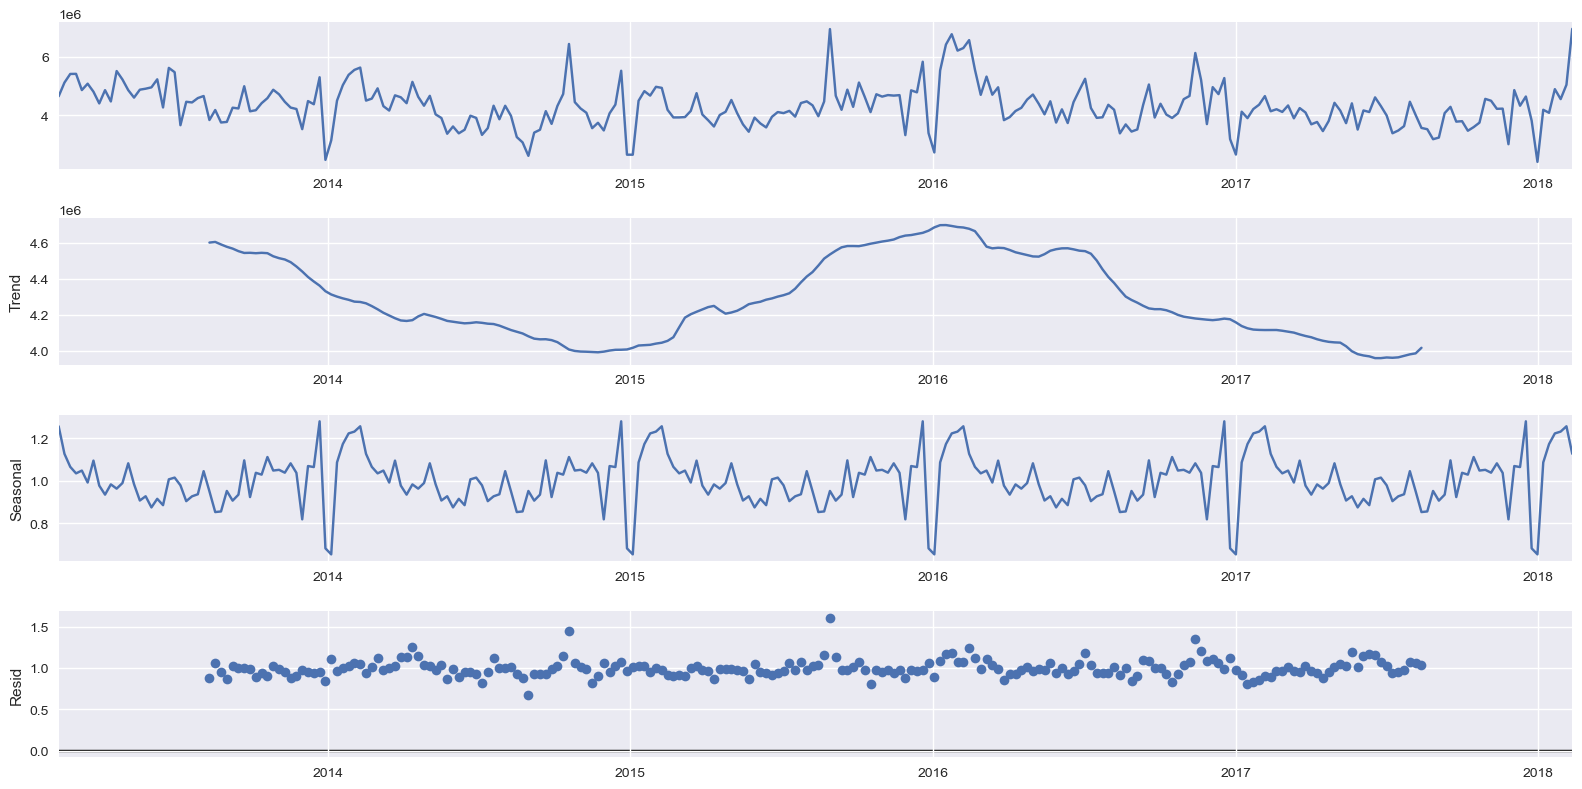

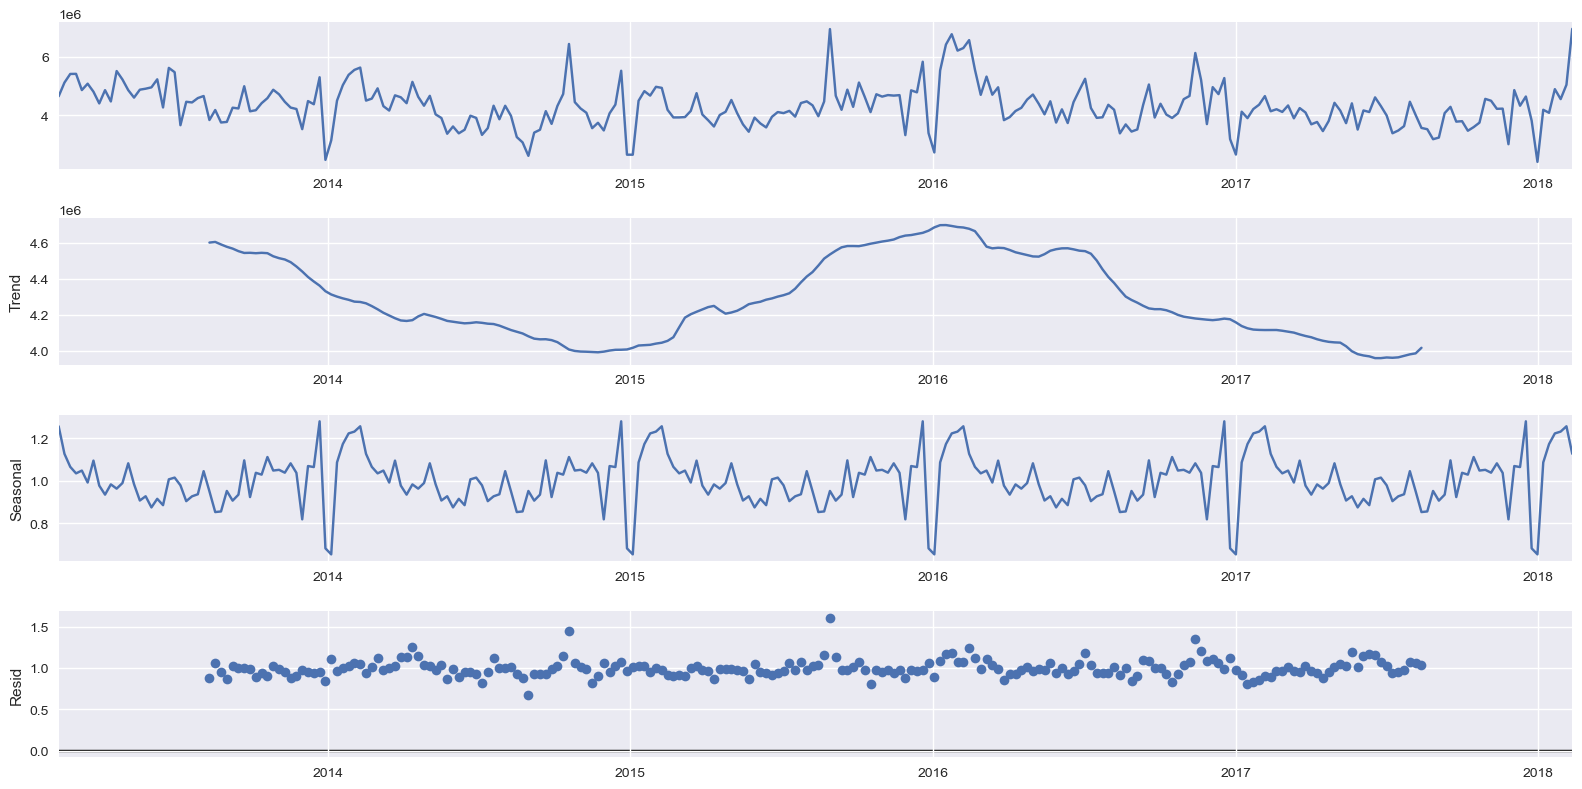

In [20]:

seasonal_decomp = seasonal_decompose(grouped_by_date['volume'].to_frame(), model="mult")
seasonal_decomp.plot()

In [21]:
# create the DF
seasonal_df = grouped_by_date['volume'].to_frame()

# calculate the trend component
seasonal_df["trend"] = seasonal_df["volume"].rolling(window=10, center=True).mean()

# detrend the series
seasonal_df["detrended"] = seasonal_df["volume"] - seasonal_df["trend"]

# calculate the seasonal component
seasonal_df.index = pd.to_datetime(seasonal_df.index)
seasonal_df["month"] = seasonal_df.index.month
seasonal_df["seasonality"] = seasonal_df.groupby("month")["detrended"].transform("mean")

# get the residuals
seasonal_df["resid"] = seasonal_df["detrended"] - seasonal_df["seasonality"]

# display the DF
seasonal_df.head(15)

,volume,trend,detrended,month,seasonality,resid
date,,,,,,
2013-02-10,4.643484e+06,NaN,NaN,2,180991.792000,NaN
2013-02-17,5.112946e+06,NaN,NaN,2,180991.792000,NaN
2013-02-24,5.408867e+06,NaN,NaN,2,180991.792000,NaN
2013-03-03,5.412355e+06,NaN,NaN,3,-87487.555274,NaN
2013-03-10,4.856800e+06,NaN,NaN,3,-87487.555274,NaN
2013-03-17,5.075298e+06,4.903207e+06,172090.937059,3,-87487.555274,259578.492333
2013-03-24,4.801778e+06,4.989703e+06,-187924.234370,3,-87487.555274,-100436.679096
2013-03-31,4.399975e+06,5.000448e+06,-600472.209177,3,-87487.555274,-512984.653903
2013-04-07,4.853825e+06,4.944985e+06,-91159.812108,4,-48253.124702,-42906.687406


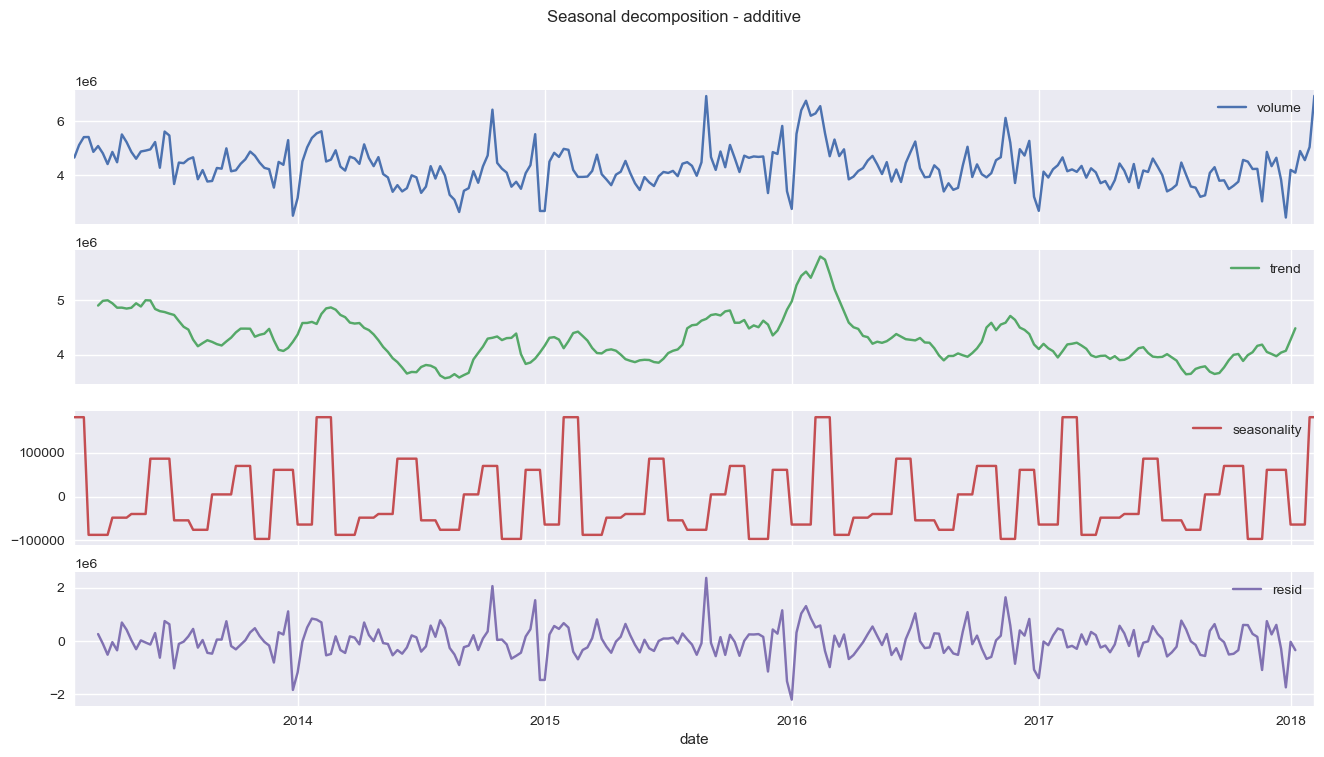

In [25]:
(
    seasonal_df
    .loc[:, ["volume", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

# Forecasting

In [26]:
from datetime import datetime, timedelta
#pd.options.plotting.backend = 'plotly'

# using grouped_by_date

train_df = grouped_by_date[grouped_by_date.index<= datetime(2018,1,1)]
test_df = grouped_by_date[grouped_by_date.index> datetime(2018,1,1)]

In [27]:

train_df

,open,high,low,close,volume
date,,,,,
2013-02-10,58.068730,58.659286,57.802352,58.368654,4.643484e+06
2013-02-17,58.386280,58.833577,57.945612,58.414417,5.112946e+06
2013-02-24,58.177193,58.641850,57.567703,58.068228,5.408867e+06
2013-03-03,57.832404,58.486691,57.215522,57.827871,5.412355e+06
2013-03-10,59.116788,59.623997,58.686228,59.249464,4.856800e+06
...,...,...,...,...,...
2017-12-03,105.372954,106.495140,104.204040,105.550798,4.854796e+06
2017-12-10,105.777643,106.843550,104.698134,105.642360,4.320646e+06
2017-12-17,106.409160,107.250585,105.533234,106.291592,4.636101e+06


In [28]:
test_df

,open,high,low,close,volume
date,,,,,
2018-01-07,108.425020,109.530807,107.572918,108.774285,4.181817e+06
2018-01-14,110.253504,111.287263,109.425013,110.558110,4.078885e+06
2018-01-21,112.100092,113.047965,110.977412,111.986552,4.888104e+06
2018-01-28,113.822966,114.897633,112.739720,114.078832,4.547839e+06
2018-02-04,113.502741,114.629154,112.007409,112.941339,5.037919e+06
2018-02-11,107.502277,110.134866,105.403882,107.514554,6.954559e+06


# Exponential Smooting

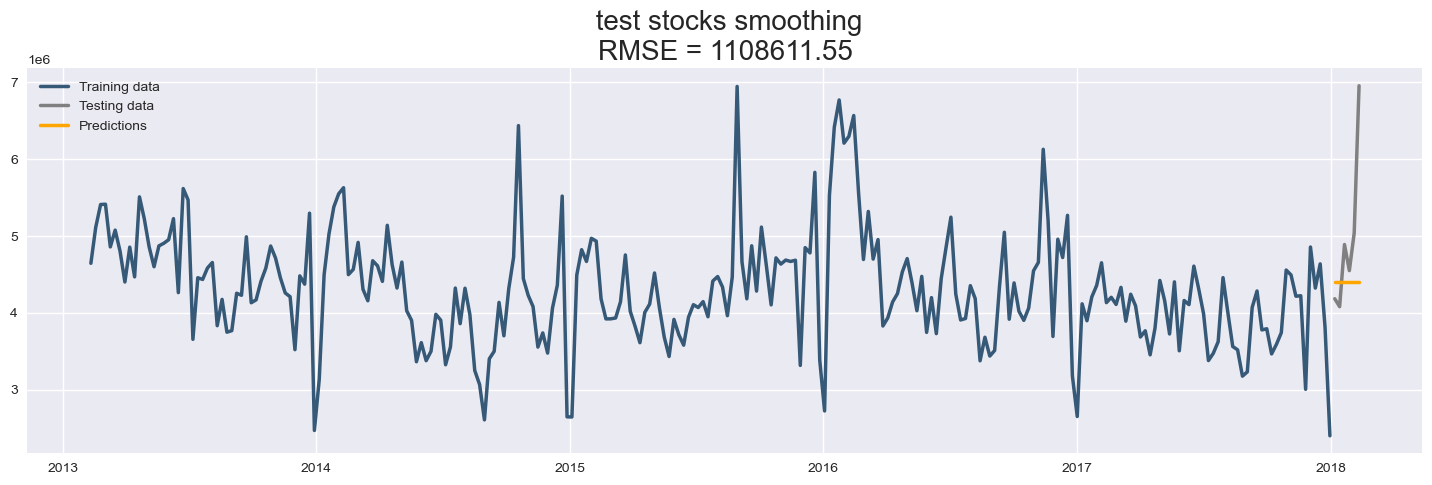

In [29]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

# Model parameters
span = 500
alpha = 2 / (span + 1)

# Train the model
model = SimpleExpSmoothing(train_df['volume'])
results = model.fit(smoothing_level=alpha, optimized=False)
predictions = results.forecast(steps=6)

# Evaluate
rmse = mean_squared_error(test_df['volume'], predictions, squared=False)

# Plot
plt.title(f' test stocks smoothing\nRMSE = {np.round(rmse, 2)}', size=20)
plt.plot(train_df['volume'], label='Training data')
plt.plot(test_df['volume'], color='gray', label='Testing data')
plt.plot(predictions, color='orange', label='Predictions')
plt.legend()

# Double Exponential Smooting

c:\Users\ramon.galang\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ramon.galang\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


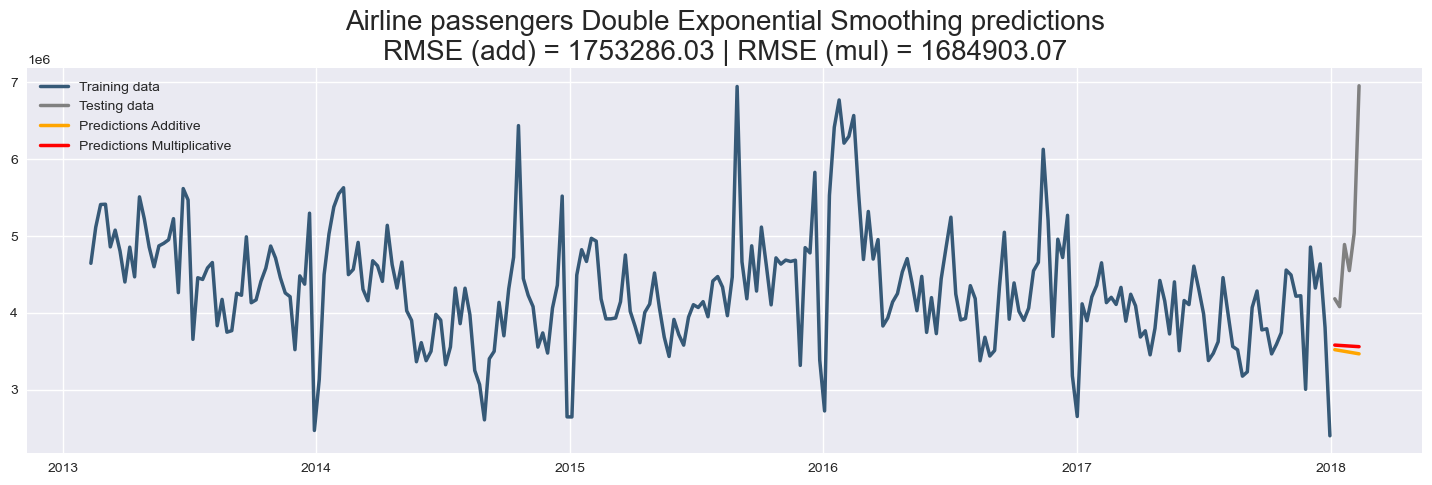

In [30]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Additive model
model_add = ExponentialSmoothing(train_df['volume'], trend='add')
results_add = model_add.fit()
predictions_add = results_add.forecast(steps=6)

# Multiplicative model
model_mul = ExponentialSmoothing(train_df['volume'], trend='mul')
results_mul = model_mul.fit(
)
predictions_mul = results_mul.forecast(steps=6)

# Evaluate
rmse_add = mean_squared_error(test_df['volume'], predictions_add, squared=False)
rmse_mul = mean_squared_error(test_df['volume'], predictions_mul, squared=False)

# Plot
plt.title(f'Airline passengers Double Exponential Smoothing predictions\nRMSE (add) = {np.round(rmse_add, 2)} | RMSE (mul) = {np.round(rmse_mul, 2)}', size=20)
plt.plot(train_df['volume'], label='Training data')
plt.plot(test_df['volume'], color='gray', label='Testing data')
plt.plot(predictions_add, color='orange', label='Predictions Additive')
plt.plot(predictions_mul, color='red', label='Predictions Multiplicative')
plt.legend()

# Triple Exponential Smoothing

[0.19149751053236308, 0.1362583458236817, 0.16644474034620507]


c:\Users\ramon.galang\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ramon.galang\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


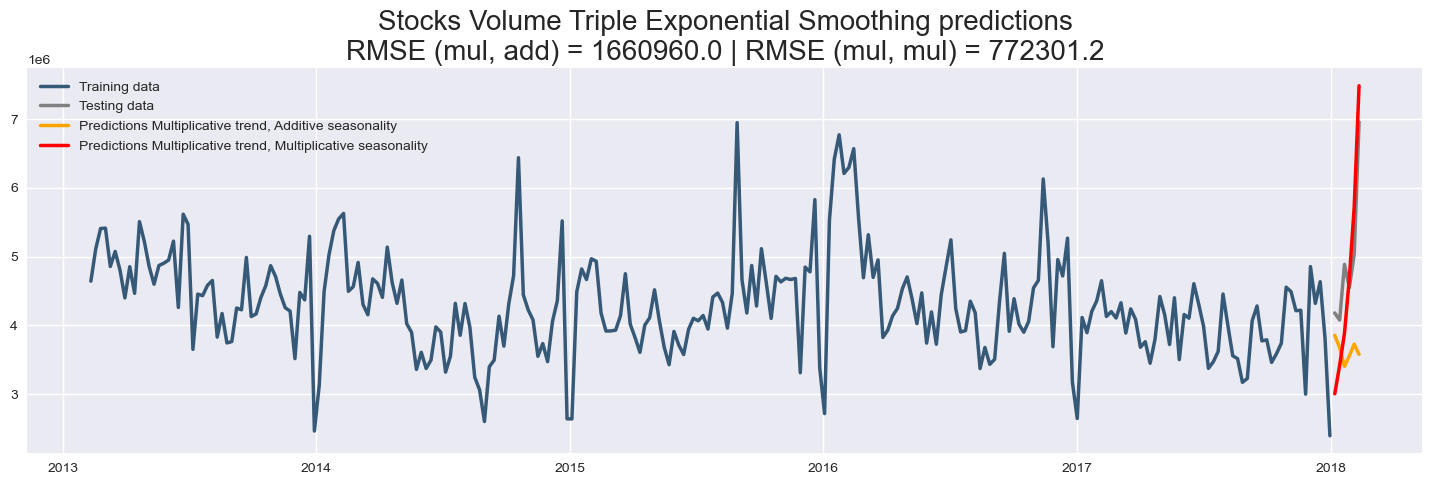

In [31]:
import random
# Multiplicative trend / Additive seasonality model
model_mul_add = ExponentialSmoothing(train_df['volume'], trend='mul', seasonal='add', seasonal_periods=12)
span_list = random.sample(range(1500, 10000), 3)
alph_list = [1000/x for x  in span_list]
print(alph_list)
results_mul_add = model_mul_add.fit()
predictions_mul_add = results_mul_add.forecast(steps=6)

# Multiplicative trend / Multiplicative seasonality model
model_mul_mul = ExponentialSmoothing(train_df['volume'], trend='mul', seasonal='mul', seasonal_periods=12)
results_mul_mul = model_mul_mul.fit(smoothing_trend=0.5, smoothing_level=0.4, smoothing_seasonal=0.34)
predictions_mul_mul = results_mul_mul.forecast(steps=6)

# Evaluate
rmse_mul_add = mean_squared_error(test_df['volume'], predictions_mul_add, squared=False)
rmse_mul_mul = mean_squared_error(test_df['volume'], predictions_mul_mul, squared=False)

# Plot
plt.title(f'Stocks Volume Triple Exponential Smoothing predictions\nRMSE (mul, add) = {np.round(rmse_mul_add, 2)} | RMSE (mul, mul) = {np.round(rmse_mul_mul, 2)}', size=20)
plt.plot(train_df['volume'], label='Training data')
plt.plot(test_df['volume'], color='gray', label='Testing data')
plt.plot(predictions_mul_add, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
plt.plot(predictions_mul_mul, color='red', label='Predictions Multiplicative trend, Multiplicative seasonality')
plt.legend()

In [32]:
grouped_by_date.values[3]

array([5.78324039e+01, 5.84866907e+01, 5.72155224e+01, 5.78278711e+01,
       5.41235497e+06])

In [34]:

import pmdarima as pm
y = df.volume.values
# Fit model
model = pm.auto_arima(train_df, seasonal=True, m=12)
auto_arima_forecast = model.predict(test_df.shape[0])


# Evaluate
rmse_auto_arima = mean_squared_error(test_df['volume'], auto_arima_forecast, squared=False)


x = np.arange(y.shape[0])
# Plot
plt.title(f'Airline volume Auto ARIMA Predictions \nRMSE = {np.round(rmse_auto_arima, 2)}', size=20)
plt.plot(train_df['volume'], label='Training data')
plt.plot(test_df['volume'], color='gray', label='Testing data')
plt.plot(auto_arima_forecast, color='orange', label='Predictions Additive')
plt.legend()

ValueError: y should be a 1d array, got an array of shape (256, 5) instead.